In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import itertools
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("train.csv")
data.head()

class_distribution = data['readmitted'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)

Class Distribution:
readmitted
0    0.5436
1    0.4564
Name: proportion, dtype: float64


In [ ]:
# Simplifies age categories to '40-60' and '60-90'
age_columns = [col for col in data.columns if col.startswith('age_')]

if age_columns:
    # Identify the highest one-hot encoded age value per row
    data['simplified_age'] = data[age_columns].idxmax(axis=1).apply(lambda x: x.split('_')[1])

    def simplify_age(age):
        if age in ['[40-50)', '[50-60)']:
            return '40-60'
        elif age in ['[60-70)', '[70-80)', '[80-90)']:
            return '60-90'
        else:
            return 'Other'

    data['simplified_age'] = data['simplified_age'].apply(simplify_age)
    print("Simplified Age Categories Created.")
else:
    print("Error: No age-related columns found.")

# Simplifies race columns into minority (1) or non-minority (0)
race_columns = [col for col in data.columns if col.startswith('race_')]
print("Race-related columns:", race_columns)

if race_columns:
    # Create a minority indicator based on available race data
    if 'race_Caucasian' in data.columns:
        data['race_minority'] = data['race_Caucasian'].apply(lambda x: 0 if x else 1)
        print("Race Minority Indicator created successfully.")
    else:
        # General minority indicator if Caucasian column is not available
        data['race_minority'] = data[race_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
        print("General Race Minority Indicator created.")
else:
    print("Error: No race-related columns found.")

# Drop original race columns (optional)
if race_columns:
    data = data.drop(columns=race_columns)

# Apply target mean mapping to gender and diabetic columns
for col in ["gender", "diabetic"]:
    if col in data.columns:
        target_mean = data.groupby(col)["readmitted"].mean()
        data[col] = data[col].map(target_mean).fillna(0)
        print(f"Target mean mapping applied for {col}")

# Handle missing values in continuous columns
for col in continuous_cols:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

# Handle missing values in categorical columns
categorical_cols = [col for col in data.columns if col not in continuous_cols + ["readmitted"]]
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].fillna("missing")

print("Missing values handled successfully.")

# Standardize continuous variables
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])
print("Continuous variables standardized.")

# Debugging output
print("Processed Data Head:")
print(data.head())

Simplified Age Categories Created.
Race-related columns: []
Error: No race-related columns found.


TypeError: Cannot setitem on a Categorical with a new category (missing), set the categories first

Simplified Age Categories Created.
Race-related columns: ['race_Caucasian', 'race_AfricanAmerican', 'race_minority']
Race Minority Indicator created successfully.
Missing values handled successfully.
Continuous variables standardized.
Processed Data Head:
   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0          3.210974           -0.099154        -0.78639        -0.615281   
1         -0.800921           -0.655597        -0.78639        -0.491940   
2          0.202052            1.165490        -0.78639         0.741474   
3         -0.466597            1.013732        -0.78639        -0.985305   
4          0.202052           -0.149740        -0.78639        -1.231988   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0          -0.298858         -0.206805         -0.509172         -0.731704   
1          -0.298858         -0.206805          0.282697          0.813976   
2           0.517872         -0.206805          1.074

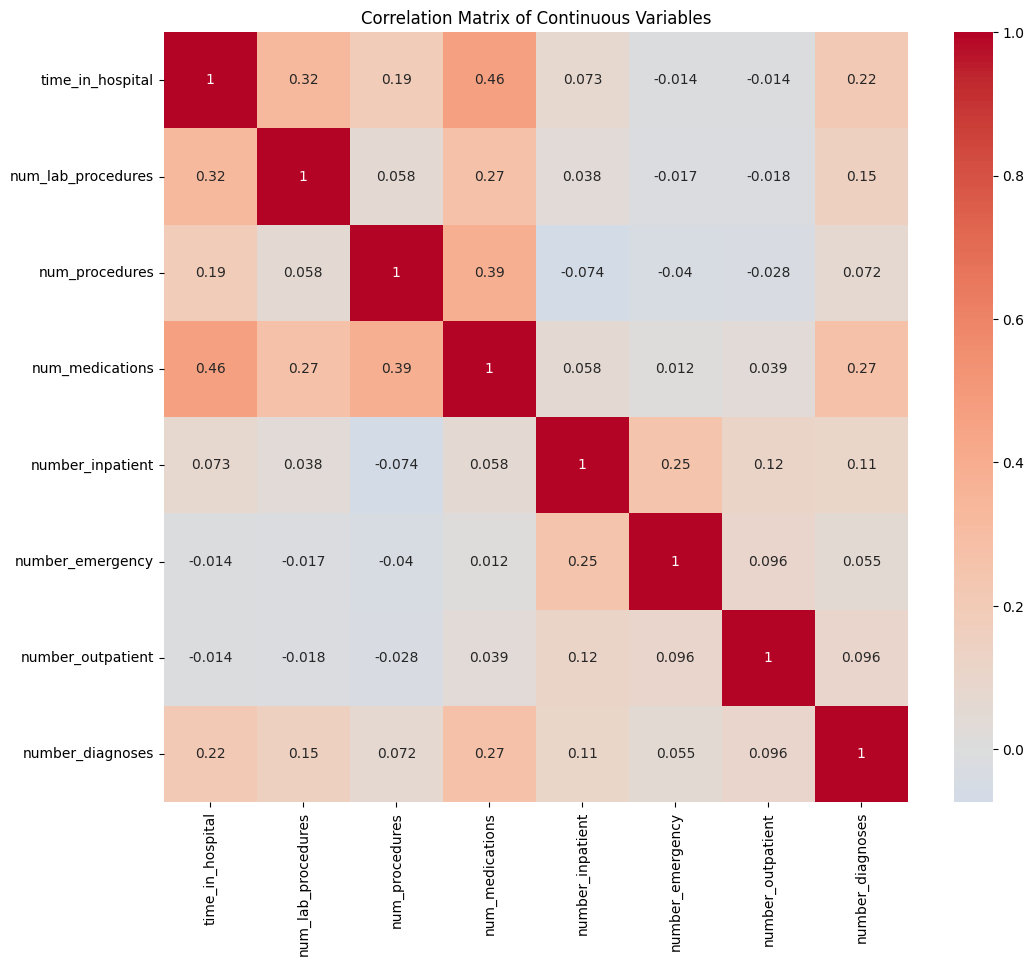

Pipeline preprocessing defined successfully.
  simplified_age
0          40-60
1          40-60
2          60-90
3          40-60
4          60-90


In [ ]:
# Stores distinct columns for continuous variables and categorical (discrete) variables
demographic_factors = ["age", "race", "gender", "diabetic"]
continuous_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_inpatient", "number_emergency", "number_outpatient", "number_diagnoses"
]
categorical_cols = [col for col in data.columns if col not in continuous_cols + ["readmitted"]]
age_columns = [col for col in data.columns if col.startswith('age_')]

# Simplifies age categories to be a medium age (40-60) and an old age (60-90)
if age_columns:
    data['simplified_age'] = data[age_columns].idxmax(axis=1).apply(lambda x: x.split('_')[1])

    def simplify_age(age):
        if age in ['[40-50)', '[50-60)']:
            return '40-60'
        elif age in ['[60-70)', '[70-80)', '[80-90)']:
            return '60-90'
        else:
            return 'Other'

    data['simplified_age'] = data['simplified_age'].apply(simplify_age)
    print("Simplified Age Categories Created.")
else:
    print("Error: No age-related columns found.")

# Simplifies race columns to be minority race or non-minority race
race_columns = [col for col in data.columns if col.startswith('race_')]
print("Race-related columns:", race_columns)

if 'race_Caucasian' in data.columns:
    data['race_minority'] = data['race_Caucasian'].apply(lambda x: 0 if x else 1)
    print("Race Minority Indicator created successfully.")
    data = data.drop(columns=race_columns)
else:
    print("Error: 'race_Caucasian' column is missing. Cannot create 'race_minority' indicator.")

for col in ["gender", "diabetic"]:
    if col in data.columns:
        target_mean = data.groupby(col)["readmitted"].mean()
        data[col] = data[col].map(target_mean).fillna(0)
        print(f"Target mean mapping applied for {col}")

# Filling in data entries in the continuous columns with the median of the column
for col in continuous_cols:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

# Filling in data entries in the categorical columns with the missing values
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].fillna("missing")

print("Missing values handled successfully.")

# Implementing data preprocessing including standard scaling for continuous variables and
# one-hot encoding for categorical variables
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])
print("Continuous variables standardized.")

print("Processed Data Head:")
print(data.head())

plt.figure(figsize=(12, 10))
sns.heatmap(data[continuous_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Continuous Variables")
plt.show()

X = data.drop(columns=["readmitted"])
y = data["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["simplified_age", "gender", "diabetic", "race_minority"])
    ]
)

print("Pipeline preprocessing defined successfully.")
print(data[['simplified_age']].head())


In [ ]:
# Inspect column names in the dataset
print("Available columns:", data.columns)

# Identify continuous and categorical columns dynamically
continuous_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_inpatient", "number_emergency", "number_outpatient", "number_diagnoses"
]
categorical_cols = [col for col in data.columns if col not in continuous_cols + ["readmitted"]]

# Handle missing values
if any(col in data.columns for col in continuous_cols):
    data[continuous_cols] = data[continuous_cols].fillna(data[continuous_cols].median())
else:
    print("No continuous columns found.")

if any(col in data.columns for col in categorical_cols):
    data[categorical_cols] = data[categorical_cols].fillna("missing")
else:
    print("No categorical columns found.")

# Standardize continuous variables
if any(col in data.columns for col in continuous_cols):
    scaler = StandardScaler()
    data[continuous_cols] = scaler.fit_transform(data[continuous_cols])
    print("Continuous variables standardized.")
else:
    print("No continuous columns to standardize.")

# One-hot encode categorical variables
if any(col in data.columns for col in categorical_cols):
    one_hot = pd.get_dummies(data[categorical_cols], drop_first=True)
    data = pd.concat([data.drop(columns=categorical_cols), one_hot], axis=1)
    print("Categorical variables one-hot encoded.")
else:
    print("No categorical columns to encode.")

# Validate the preprocessing
print("Preprocessed Data:")
print(data.head())



Available columns: Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'readmitted', 'gender_Female',
       'age_[70-80)', 'age_[60-70)', 'age_[50-60)', 'age_[80-90)',
       'age_[40-50)', 'payer_code_?', 'payer_code_MC', 'payer_code_HM',
       'payer_code_SP', 'payer_code_BC', 'medical_specialty_?',
       'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
       'tolbut

In [ ]:
# Check available race-related columns and recreate 'race_minority'
race_columns = [col for col in data.columns if col.startswith('race_')]
print("Available race-related columns:", race_columns)

if 'race_Caucasian' in data.columns:
    data['race_minority'] = data['race_Caucasian'].apply(lambda x: 0 if x else 1)
    print("Created 'race_minority' column.")
else:
    print("Error: 'race_Caucasian' column is missing. Cannot create 'race_minority'.")

# One-hot encode 'simplified_age' if needed
if 'simplified_age' in data.columns:
    one_hot = pd.get_dummies(data['simplified_age'], prefix='simplified_age', drop_first=False)
    data = pd.concat([data, one_hot], axis=1)
    print("One-hot encoded 'simplified_age'.")
else:
    print("Error: 'simplified_age' column is missing.")

# Validate features and prepare data
features = [
    'race_minority', 'simplified_age_40-60', 'simplified_age_60-90', 'gender_Female',
    'num_procedures', 'num_medications', 'num_lab_procedures',
    'number_inpatient', 'number_diagnoses'
]
target = 'readmitted'

missing_features = [col for col in features if col not in data.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
    features = [col for col in features if col in data.columns]

assert target in data.columns, "Target column is missing."

# Prepare data
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop rows with missing values and align y_train
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

# Add constant to X_train for statsmodels
X_train_sm = sm.add_constant(X_train)

# Convert boolean columns to integers
bool_columns = X_train_sm.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    print(f"Converting boolean columns to integers: {list(bool_columns)}")
    X_train_sm[bool_columns] = X_train_sm[bool_columns].astype(int)

# Ensure all data is numeric
X_train_sm = X_train_sm.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')

# Drop rows with missing values in X_train_sm or y_train
X_train_sm = X_train_sm.dropna()
y_train = y_train.loc[X_train_sm.index]

# Validate consistency between X_train_sm and y_train
assert X_train_sm.shape[0] == y_train.shape[0], "Mismatched rows between X_train_sm and y_train"

# Logistic Regression with statsmodels
print_separator("Fitting Logistic Regression with statsmodels:")
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
print(result.summary())

# Extract significant features
significant_features = result.pvalues[result.pvalues < 0.05].index.tolist()
print_separator("Significant Features Influencing Readmission:")
print(significant_features)


Available race-related columns: []
Error: 'race_Caucasian' column is missing. Cannot create 'race_minority'.
Error: 'simplified_age' column is missing.
Missing features: ['race_minority', 'simplified_age_40-60']
Converting boolean columns to integers: ['simplified_age_60-90', 'gender_Female']

----------------------------------------
Fitting Logistic Regression with statsmodels:
----------------------------------------
Optimization terminated successfully.
         Current function value: 0.656135
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19992
Method:                           MLE   Df Model:                            7
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                 0.04833
Time:                        22:26:16   Log-Likelihood:                -13123.
c

<ipython-input-26-18fc0373e999>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='readmitted', y='interaction_inpatient_diagnoses', data=data, ci=None)


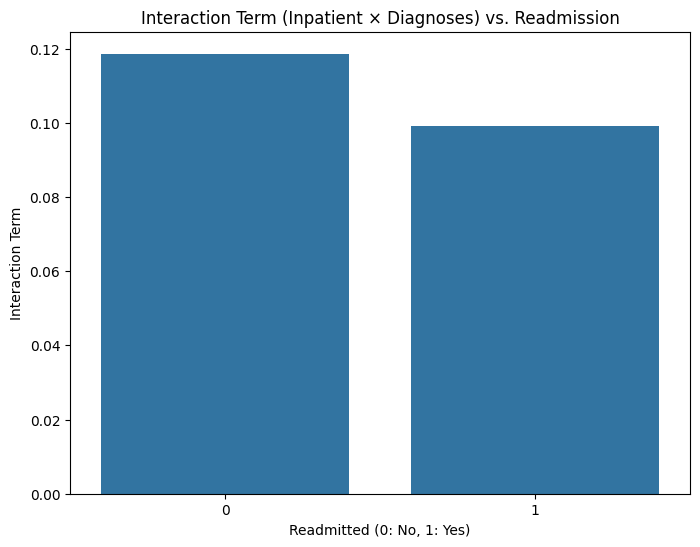

<ipython-input-26-18fc0373e999>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='num_medications_binned', y='readmitted', data=data, ci=None)


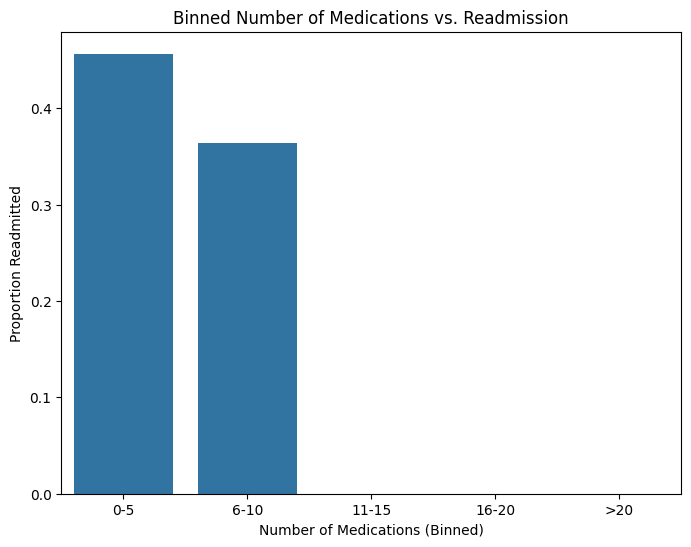

New features created and visualized: ['interaction_inpatient_diagnoses', 'num_medications_binned']
   interaction_inpatient_diagnoses num_medications_binned  readmitted
0                         0.372563                    0-5           0
1                         0.230109                    0-5           1
2                         0.874671                    0-5           1
3                        -0.152115                    0-5           1
4                         0.230109                    0-5           0


In [ ]:
data['interaction_inpatient_diagnoses'] = data['number_inpatient'] * data['number_diagnoses']

num_medications_bins = pd.cut(data['num_medications'], bins=[-float('inf'), 5, 10, 15, 20, float('inf')],
                              labels=['0-5', '6-10', '11-15', '16-20', '>20'])
data['num_medications_binned'] = num_medications_bins

plt.figure(figsize=(8, 6))
sns.barplot(x='readmitted', y='interaction_inpatient_diagnoses', data=data, ci=None)
plt.title('Interaction Term (Inpatient × Diagnoses) vs. Readmission')
plt.xlabel('Readmitted (0: No, 1: Yes)')
plt.ylabel('Interaction Term')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='num_medications_binned', y='readmitted', data=data, ci=None)
plt.title('Binned Number of Medications vs. Readmission')
plt.xlabel('Number of Medications (Binned)')
plt.ylabel('Proportion Readmitted')
plt.show()

new_features = ['interaction_inpatient_diagnoses', 'num_medications_binned']
print("New features created and visualized:", new_features)

print(data[['interaction_inpatient_diagnoses', 'num_medications_binned', 'readmitted']].head())


In [ ]:
demographic_features = {
    'race_minority': [0, 1],
    'gender_Female': [0, 1],
    'simplified_age_60-90': [0, 1]
}

combinations = list(itertools.product(*demographic_features.values()))

combinations_df = pd.DataFrame(combinations, columns=demographic_features.keys())

print("Possible Demographic Combinations for Treatment Plans:")
print(combinations_df)


Possible Demographic Combinations for Treatment Plans:
   race_minority  gender_Female  simplified_age_60-90
0              0              0                     0
1              0              0                     1
2              0              1                     0
3              0              1                     1
4              1              0                     0
5              1              0                     1
6              1              1                     0
7              1              1                     1


In [ ]:
demographic_features = ['race_minority', 'gender_Female', 'simplified_age_60-90']
demographic_combinations = data.groupby(demographic_features)

optimal_treatment_plans = []

for group, group_data in demographic_combinations:
    non_readmitted = group_data[group_data['readmitted'] == 0]

    optimal_plan = {
        'Demographic Combination': group,
        'Avg_Num_Procedures': non_readmitted['num_procedures'].mean(),
        'Avg_Num_Medications': non_readmitted['num_medications'].mean(),
        'Avg_Interaction_Inpatient_Diagnoses': non_readmitted['interaction_inpatient_diagnoses'].mean(),
        'Readmission Rate': group_data['readmitted'].mean()
    }

    optimal_treatment_plans.append(optimal_plan)

optimal_treatment_df = pd.DataFrame(optimal_treatment_plans)

print("Optimal Treatment Plans by Demographic Group:")
print(optimal_treatment_df)

display(optimal_treatment_df)

optimal_treatment_df.to_csv("optimal_treatment_plans.csv", index=False)
print("Optimal treatment plans saved to 'optimal_treatment_plans.csv'.")


KeyError: 'race_minority'

In [ ]:
demographic_factors = ["age", "race", "gender", "diabetic"]
continuous_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_inpatient", "number_emergency", "number_outpatient", "number_diagnoses"
]
categorical_cols = [col for col in data.columns if col not in continuous_cols + ["readmitted"]]

age_columns = [col for col in data.columns if col.startswith('age_')]

if age_columns:
    data['simplified_age'] = data[age_columns].idxmax(axis=1).apply(lambda x: x.split('_')[1])

    def simplify_age(age):
        if age in ['[40-50)', '[50-60)']:
            return '40-60'
        elif age in ['[60-70)', '[70-80)', '[80-90)']:
            return '60-90'
        else:
            return 'Other'

    data['simplified_age'] = data['simplified_age'].apply(simplify_age)
    print("Simplified Age Categories Created.")
else:
    print("Error: No age-related columns found.")

race_columns = [col for col in data.columns if col.startswith('race_')]
print("Race-related columns:", race_columns)

if 'race_Caucasian' in data.columns:
    data['race_minority'] = data['race_Caucasian'].apply(lambda x: 0 if x else 1)
    print("Race Minority Indicator created successfully.")
    data = data.drop(columns=race_columns)
else:
    print("Error: 'race_Caucasian' column is missing. Cannot create 'race_minority' indicator.")

for col in ["gender", "diabetic"]:
    if col in data.columns:
        target_mean = data.groupby(col)["readmitted"].mean()
        data[col] = data[col].map(target_mean).fillna(0)
        print(f"Target mean mapping applied for {col}")

for col in continuous_cols:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].fillna("missing")

print("Missing values handled successfully.")

scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])
print("Continuous variables standardized.")

print("Processed Data Head:")
print(data.head())

plt.figure(figsize=(12, 10))
sns.heatmap(data[continuous_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Continuous Variables")
plt.show()

X = data.drop(columns=["readmitted"])
y = data["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["simplified_age", "gender", "diabetic", "race_minority"])
    ]
)

print("Pipeline preprocessing defined successfully.")
print(data[['simplified_age']].head())

In [ ]:

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Define continuous and categorical features
continuous_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_inpatient", "number_emergency", "number_outpatient", "number_diagnoses"
]
categorical_cols = ["age", "gender", "race", "diabetic"]

# Handle missing values
data[continuous_cols] = data[continuous_cols].fillna(data[continuous_cols].median())
data[categorical_cols] = data[categorical_cols].fillna("missing")

# Standardize continuous variables
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

# One-hot encode categorical variables
one_hot = pd.get_dummies(data[categorical_cols], drop_first=True)
data = pd.concat([data.drop(columns=categorical_cols), one_hot], axis=1)

# Validate the preprocessing
print("Preprocessed Data:")
print(data.head())


In [ ]:
grouped_data = data.groupby(['race_minority', 'simplified_age', 'readmitted'])[continuous_cols].mean().reset_index()

print("Group-Level Statistics for Continuous Variables:")
print(grouped_data)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_data, x='simplified_age', y='num_medications', hue='race_minority', ci=None)
plt.title("Average Number of Medications by Age and Race Minority Status")
plt.ylabel("Average Number of Medications")
plt.show()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features = ['race_minority', 'simplified_age', 'num_procedures', 'num_medications', 'num_lab_procedures']
X = pd.get_dummies(data[features], drop_first=True)
y = data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Feature Importance (Logistic Regression Coefficients):")
print(coefficients)

def simulate_treatment_effect(race_minority, age_group, num_procedures, num_medications, num_lab_procedures):
    input_data = pd.DataFrame({
        'race_minority': [race_minority],
        'num_procedures': [num_procedures],
        'num_medications': [num_medications],
        'num_lab_procedures': [num_lab_procedures],
        'simplified_age_60-90': [1 if age_group == '60-90' else 0]
    })
    readmission_prob = model.predict_proba(input_data)[:, 1]
    return readmission_prob[0]

print("\nSimulated Treatment Effect:")
example_prob = simulate_treatment_effect(
    race_minority=1, age_group='40-60', num_procedures=2, num_medications=10, num_lab_procedures=40
)
print(f"Predicted Readmission Probability: {example_prob:.2f}")



In [ ]:
def simulate_treatment_grid(race_minority, age_group, num_lab_procedures, model):
    num_medications_range = np.arange(0, 21, 2)
    num_procedures_range = np.arange(0, 6, 1)
    results = []

    for num_medications in num_medications_range:
        for num_procedures in num_procedures_range:
            input_data = pd.DataFrame({
                'race_minority': [race_minority],
                'num_procedures': [num_procedures],
                'num_medications': [num_medications],
                'num_lab_procedures': [num_lab_procedures],
                'simplified_age_60-90': [1 if age_group == '60-90' else 0]
            })
            prob = model.predict_proba(input_data)[:, 1][0]
            results.append({
                'num_medications': num_medications,
                'num_procedures': num_procedures,
                'readmission_prob': prob
            })

    return pd.DataFrame(results)

print("Simulating Optimized Treatments...")
results_df = simulate_treatment_grid(
    race_minority=1,
    age_group='40-60',
    num_lab_procedures=40,
    model=model
)

optimal_treatment = results_df.loc[results_df['readmission_prob'].idxmin()]
print("\nOptimal Treatment Combination:")
print(optimal_treatment)

plt.figure(figsize=(12, 8))
pivot_table = results_df.pivot(index="num_procedures", columns="num_medications", values="readmission_prob")
sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': 'Readmission Probability'})
plt.title("Readmission Probability Heatmap (Num Medications vs Num Procedures)")
plt.xlabel("Number of Medications")
plt.ylabel("Number of Procedures")
plt.show()



In [ ]:
features = ['race_minority', 'num_procedures', 'num_medications', 'num_lab_procedures', 'simplified_age_60-90']
encoded_data = pd.get_dummies(data, columns=['simplified_age'], drop_first=True)
X = encoded_data[features]
y = encoded_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data Split Completed: Training Size =", len(X_train), ", Test Size =", len(X_test))

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)
print("Logistic Regression Model with Class Weights Trained Successfully!")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

xgboost_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=42, eval_metric='logloss'))
    ]
)

X = data.drop(columns=["readmitted"])
y = data["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost_pipeline.fit(X_train, y_train)
print("XGBoost Pipeline Trained Successfully!")

y_pred = xgboost_pipeline.predict(X_test)
y_pred_proba = xgboost_pipeline.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

print("\nConfusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nEvaluation Metrics:")
print(f"Accuracy: {xgboost_pipeline.score(X_test, y_test):.2f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
